### Sampling - Baseline : Random Features + GRU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Virtual Metrology Model (statistical features)

In [2]:
from sklearn.metrics import mean_squared_error
from scipy.stats import kurtosis, skew

In [3]:
# add the latest MRR column
def get_orig_data(dataset):
    
    train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0).reset_index(drop=True)
    test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0).reset_index(drop=True)

    short_sampled_orig = train_orig.iloc[316*2:, :].reset_index(drop=True)
    latest_mrr_sampled = train_orig.iloc[:-316*2, -1].rename('latest_mrr').reset_index(drop=True)
    addmrr_sampled_orig = pd.concat([short_sampled_orig, latest_mrr_sampled], axis=1)

    short_unsampled_orig = train_orig.iloc[316*1:, :].reset_index(drop=True)
    latest_mrr_unsampled = train_orig.iloc[:-316*1, -1].rename('latest_mrr').reset_index(drop=True)
    addmrr_unsampled_orig = pd.concat([short_unsampled_orig, latest_mrr_unsampled], axis=1)

    latest_mrr_test = pd.concat([train_orig.iloc[-316*1:, -1], test_orig.iloc[:-316*1, -1]], ignore_index=True).rename("latest_mrr").reset_index(drop=True)
    addmrr_test_orig = pd.concat([test_orig, latest_mrr_test], axis=1)
    
    return addmrr_sampled_orig, addmrr_unsampled_orig, addmrr_test_orig

# transfer into the input data
def get_stats_features(data):
    orig_X = data.iloc[:, :-2].to_numpy()
    orig_X = orig_X.reshape(-1, 316, orig_X.shape[1])
    orig_y = data.iloc[:, -2].tolist()
    data_y = [orig_y[i] for i in range(0, len(orig_y), 316)]
    # create the latest MRR for every samples
    latest_mrr = data.iloc[:, -1].tolist()
    latest_mrr = [latest_mrr[i] for i in range(0, len(latest_mrr), 316)]
    
    # calculate the statistics features
    means = np.mean(orig_X, axis=1)
    stds = np.std(orig_X, axis=1)
    medians = np.median(orig_X, axis=1)
    mins = np.min(orig_X, axis=1)
    maxs = np.max(orig_X, axis=1)
    kurts = kurtosis(orig_X, axis=1)
    skews = skew(orig_X, axis=1)
    stats_X = np.hstack([means, stds, medians, mins, maxs, kurts, skews])
    stats_X = np.nan_to_num(stats_X, nan=0.0)

    # add the latest MRR
    latest_mrr = np.array(latest_mrr).reshape(-1,1)
    data_X = np.concatenate((stats_X, latest_mrr), axis=1)

    return data_X, data_y

# fit different ML models
def fit_XGB(X_train, y_train):
    import xgboost as xgb
    params = {
        'objective': 'reg:squarederror',  # 回歸問題
        'max_depth': 3,                    # 樹的最大深度
        'learning_rate': 0.01,              # 學習率
        'n_estimators': 200                # 樹的數量
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    return model

def fit_RF(X_train, y_train):
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=2)
    model.fit(X_train, y_train)
    return model

def fit_KNN(X_train, y_train):
    from sklearn.neighbors import KNeighborsRegressor
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)
    return model

def fit_MLP(X_train, y_train):
    from sklearn.neural_network import MLPRegressor
    model = MLPRegressor(hidden_layer_sizes=(128, 16), activation='relu', solver='adam', max_iter=2000, random_state=2)
    model.fit(X_train, y_train)
    return model

# generate the VM MRR prediction
def get_VM_predition(dataset, mode_type):  # model_type: 'XGB'/'RF'/'KNN'/"MLP"
    
    addmrr_sampled_orig, addmrr_unsampled_orig, addmrr_test_orig = get_orig_data(dataset)
    
    # retain only sampled section for training
    sampled_train_orig = pd.concat([addmrr_sampled_orig.iloc[i:i+316] for i in range(0, len(addmrr_sampled_orig), 316*2)], ignore_index=True)
    unsampled_train_orig = pd.concat([addmrr_unsampled_orig.iloc[i:i+316] for i in range(316, len(addmrr_unsampled_orig), 316*2)], ignore_index=True)
    all_test_orig = pd.concat([unsampled_train_orig, addmrr_test_orig], ignore_index=True)
    extend_test_orig = pd.concat([addmrr_unsampled_orig.iloc[-316*4:], addmrr_test_orig], ignore_index=True)

    y_pred = {}
    X_train, y_train = get_stats_features(sampled_train_orig)
    # unsampled : unsampled wafer in training set / test : testing set / all : 'unsampled and test' / extend : 'testing set extended to past wafers'(for equipment state model)
    data_modes = {'unsampled':unsampled_train_orig, 'test':addmrr_test_orig, 'all':all_test_orig, 'extend':extend_test_orig}
    for mode, data in data_modes.items():
        match mode_type:
            case 'XGB':
                model = fit_XGB(X_train, y_train)
            case 'RF':
                model = fit_RF(X_train, y_train)
            case 'KNN':
                model = fit_KNN(X_train, y_train)
            case 'MLP':
                model = fit_MLP(X_train, y_train)

        X_test, y_test = get_stats_features(data)
        pred = model.predict(X_test)
        mse = mean_squared_error(y_test, pred)

        print('------------------------------------------------')
        print(mode)
        print(f"Statistical Features + {mode_type} VM test loss", round(mse, 3))
        y_pred[mode] = model.predict(X_test)

    return y_pred

#### Random Features + GRU Model

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset

from util.env import get_device, set_device
from util.preprocess import build_loc_net, construct_data
from util.net_struct import get_feature_map, get_fc_graph_struc
from util.iostream import printsep

from datasets.TimeDataset_VM import TimeDataset

from models.Random_GRU import Random_GRU

from run.train import train
from run.test  import test
from run.evaluate import get_err_scores, get_best_performance_data, get_val_performance_data, get_full_err_scores

import sys
from datetime import datetime

import os
import argparse
from pathlib import Path

import json
import random

In [6]:
# check GPU situation
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

True
1
0
NVIDIA GeForce RTX 3090 Ti
11.8


In [7]:
# function to set random seed
def setup_seed(seed):
     random.seed(seed)
     np.random.seed(seed)
     if torch.cuda.is_available():
          torch.cuda.manual_seed(seed)
          torch.cuda.manual_seed_all(seed)
     torch.manual_seed(seed)
     torch.backends.cudnn.deterministic = True
     torch.backends.cudnn.benchmark = False

In [ ]:
class Main():
    def __init__(self, train_config, env_config, y_pred_train, y_pred_test, debug=False):

        self.train_config = train_config
        self.env_config = env_config
        self.datestr = None

        dataset = self.env_config['dataset']
        past_wafer = self.train_config['past_wafer']
        future_step = self.train_config['future_step']
        
        train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0)
        test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0)
        self.train_orig = train_orig
        self.test_orig = test_orig

        # concat the past wafer referenced from training set
        test_extend = pd.concat((train_orig.iloc[-(316 * (past_wafer + future_step - 1)):,:], test_orig), ignore_index=True)

        train_past = self.transfer_to_input(train_orig, past_wafer)
        test_extend_past = self.transfer_to_input(test_extend, past_wafer)

        train, test = train_past, test_extend_past

        if 'attack' in train.columns:
            train = train.drop(columns=['attack'])

        feature_map = get_feature_map(dataset)
        fc_struc = get_fc_graph_struc(dataset)

        set_device(env_config['device'])
        self.device = get_device()

        fc_edge_index = build_loc_net(fc_struc, list(train.columns), feature_map=feature_map)
        fc_edge_index = torch.tensor(fc_edge_index, dtype = torch.long)

        self.feature_map = feature_map

        train_dataset_indata = construct_data(train, feature_map, labels=train.MRR.tolist())
        test_dataset_indata = construct_data(test, feature_map, labels=test.MRR.tolist())

        cfg = {
            'wafer_len': train_config['wafer_len'],
            'past_wafer': train_config['past_wafer'],
            'future_step': train_config['future_step'],
        }

        train_dataset = TimeDataset(train_dataset_indata, fc_edge_index, y_pred_train, config=cfg, mode='train')
        test_dataset = TimeDataset(test_dataset_indata, fc_edge_index, y_pred_test, config=cfg, mode='test')


        train_dataloader, val_dataloader = self.get_loaders(train_dataset, train_config['seed'], train_config['batch'], val_ratio = train_config['val_ratio'])

        self.train_dataset = train_dataset
        self.test_dataset = test_dataset


        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = DataLoader(test_dataset, batch_size=train_config['batch'],
                            shuffle=False)


        edge_index_sets = []
        edge_index_sets.append(fc_edge_index)

        self.model = Random_GRU(edge_index_sets, len(feature_map),  
                dim=train_config['dim'], 
                input_dim=train_config['wafer_len'],
                topk=train_config['topk'],
                past_wafer=train_config['past_wafer'],
                gru_inter_dim=train_config['gru_inter_dim'],
                gru_layer_num=train_config['gru_layer_num']
            ).to(self.device)

    def run(self):

        if len(self.env_config['load_model_path']) > 0:
            model_save_path = self.env_config['load_model_path']
        else:
            model_save_path = self.get_save_path()[0]

            self.train_log = train(self.model, model_save_path, 
                config = self.train_config,
                train_dataloader=self.train_dataloader,
                val_dataloader=self.val_dataloader, 
                feature_map=self.feature_map,
                test_dataloader=self.test_dataloader,
                test_dataset=self.test_dataset,
                train_dataset=self.train_dataset,
                dataset_name=self.env_config['dataset']
            )
        
        # test            
        self.model.load_state_dict(torch.load(model_save_path))
        best_model = self.model.to(self.device)

        test_loss, test_result = test(best_model, self.test_dataloader)
        val_loss, val_result = test(best_model, self.val_dataloader)

        return test_loss, val_loss, test_result, val_result

    # split out the validation set and transfer into dataloaders
    def get_loaders(self, train_dataset, seed, batch, val_ratio=0.1):
        
        dataset_len = int(len(train_dataset))
        train_use_len = int(dataset_len * (1 - val_ratio))
        val_use_len = int(dataset_len * val_ratio)
        val_start_index = random.randrange(train_use_len)
        indices = torch.arange(dataset_len)

        train_sub_indices = torch.cat([indices[:val_start_index], indices[val_start_index+val_use_len:]])
        train_subset = Subset(train_dataset, train_sub_indices)

        val_sub_indices = indices[val_start_index:val_start_index+val_use_len]
        val_subset = Subset(train_dataset, val_sub_indices)

        train_dataloader = DataLoader(train_subset, batch_size=batch,
                                shuffle=False)

        val_dataloader = DataLoader(val_subset, batch_size=batch,
                                shuffle=False)

        return train_dataloader, val_dataloader

    def get_save_path(self, feature_name=''):

        dir_path = self.env_config['save_path']
        
        if self.datestr is None:
            now = datetime.now()
            self.datestr = now.strftime('%m_%d-%H_%M_%S')
        datestr = self.datestr          

        paths = [
            f'./save_path/{dir_path}/best_{datestr}.pt',
            f'./results/{dir_path}/{datestr}.csv',
        ]

        for path in paths:
            dirname = os.path.dirname(path)
            Path(dirname).mkdir(parents=True, exist_ok=True)

        return paths
    
    # reshape the input data [316, 19 x 4]
    def transfer_to_input(self, orig_data, past_wafer=4): 
        
        if not (1 <= past_wafer <= 5): # 5 can be change to max quantity of past wafers
            raise ValueError("past_wafer must be between 1 and 5")

        oldest_wafer = orig_data.iloc[:, :-1]
        wafer_list = [oldest_wafer]

        # place the SVIDs of past wafers into the column dimension
        for i in range(2, past_wafer + 1):
            wafer_n = pd.DataFrame(np.zeros_like(oldest_wafer), columns=[f'{col}_{i}' for col in oldest_wafer.columns])
            wafer_n.iloc[:-316*(i-1)] = oldest_wafer.iloc[316*(i-1):].values
            wafer_list.append(wafer_n)

        mrr = orig_data.iloc[:, -1]
        wafer_list.append(mrr)

        input_data = pd.concat(wafer_list, axis=1)

        return input_data

A456

In [ ]:
# training setting
batch=256
epoch=2000
wafer_len=316
past_wafer=4
dim=32
save_path_pattern='Random_GRU'
dataset='A456'
device='cuda'
seed=2
comment=''
decay=0
val_ratio=0.2
topk=4
report='best'
load_model_path=''
future_step=1
gru_inter_dim=64
gru_layer_num=3

# set random seed
setup_seed(seed)

train_config = {
    'batch': batch,
    'epoch': epoch,
    'wafer_len': wafer_len,
    'dim': dim,
    'comment': comment,
    'seed': seed,
    'decay': decay,
    'val_ratio': val_ratio,
    'topk': topk,
    'past_wafer' : past_wafer,
    'future_step' : future_step,
    'gru_inter_dim' : gru_inter_dim,
    'gru_layer_num' : gru_layer_num
}

env_config={
    'save_path': save_path_pattern,
    'dataset': dataset,
    'report': report,
    'device': device,
    'load_model_path': load_model_path
}

In [ ]:
# get VM MRR prediction
vm_pred = get_VM_predition(dataset,'RF')
y_pred_train = vm_pred['unsampled']
y_pred_test = vm_pred['extend']

In [ ]:
# model training
main = Main(train_config, env_config, y_pred_train, y_pred_test, debug=False)
test_loss, _, value_result, _ = main.run()

epoch (1 / 2000) (Train_loss:4101.77490234, ACU_loss:8203.54980469, Val_loss:3880.33837891)
epoch (2 / 2000) (Train_loss:4016.51550293, ACU_loss:8033.03100586, Val_loss:3800.18188477)
epoch (3 / 2000) (Train_loss:3931.63830566, ACU_loss:7863.27661133, Val_loss:3718.96093750)
epoch (4 / 2000) (Train_loss:3847.56164551, ACU_loss:7695.12329102, Val_loss:3640.00512695)
epoch (5 / 2000) (Train_loss:3764.94006348, ACU_loss:7529.88012695, Val_loss:3556.46411133)
epoch (6 / 2000) (Train_loss:3677.56774902, ACU_loss:7355.13549805, Val_loss:3470.59912109)
epoch (7 / 2000) (Train_loss:3590.62170410, ACU_loss:7181.24340820, Val_loss:3382.37451172)
epoch (8 / 2000) (Train_loss:3501.62353516, ACU_loss:7003.24707031, Val_loss:3301.31835938)
epoch (9 / 2000) (Train_loss:3412.19494629, ACU_loss:6824.38989258, Val_loss:3202.85937500)
epoch (10 / 2000) (Train_loss:3308.31445312, ACU_loss:6616.62890625, Val_loss:3110.23510742)
epoch (11 / 2000) (Train_loss:3205.83093262, ACU_loss:6411.66186523, Val_loss:2

MSE :  9.79


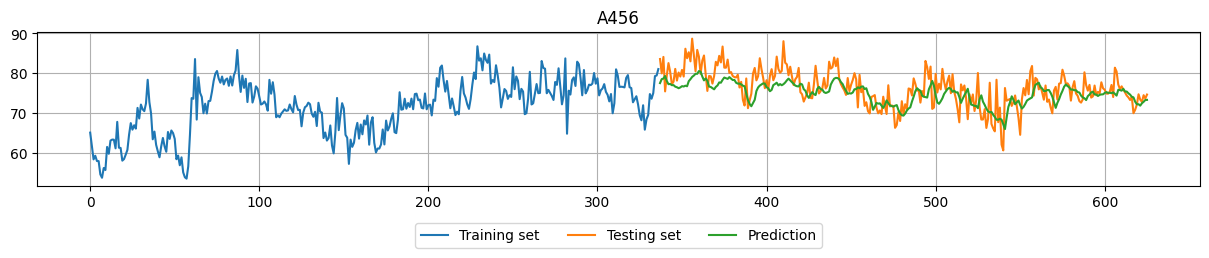

In [24]:
print('MSE : ', round(test_loss, 3))

# plot the result
y_train = [main.train_orig['MRR'][i] for i in range(0, len(main.train_orig), 316)]  
y_train = [y_train[i] for i in range(len(y_train)) if i % 2 == 0]
y_pred = np.array(value_result[0]).flatten()
y_truth = np.array(value_result[1])[:, 0].tolist()

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(len(y_train)), y_train, label='Train')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_truth, label='Test')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(['Training set', 'Testing set', 'Prediction'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.45))
plt.grid(True)
plt.show()

B456

In [9]:
# training setting
batch=256
epoch=2000
wafer_len=316
past_wafer=4
dim=32
save_path_pattern='Random_GRU'
dataset='B456'
device='cuda'
seed=2
comment=''
decay=0
val_ratio=0.2
topk=4
report='best'
load_model_path=''
future_step=1
gru_inter_dim=8
gru_layer_num=2

# set random seed
setup_seed(seed)

train_config = {
    'batch': batch,
    'epoch': epoch,
    'wafer_len': wafer_len,
    'dim': dim,
    'comment': comment,
    'seed': seed,
    'decay': decay,
    'val_ratio': val_ratio,
    'topk': topk,
    'past_wafer' : past_wafer,
    'future_step' : future_step,
    'gru_inter_dim' : gru_inter_dim,
    'gru_layer_num' : gru_layer_num
}

env_config={
    'save_path': save_path_pattern,
    'dataset': dataset,
    'report': report,
    'device': device,
    'load_model_path': load_model_path
}

In [10]:
# get VM MRR prediction
vm_pred = get_VM_predition(dataset,'RF')
y_pred_train = vm_pred['unsampled']
y_pred_test = vm_pred['extend']

------------------------------------------------
unsampled
pretain GDN-RF VM test loss 5.976
------------------------------------------------
test
pretain GDN-RF VM test loss 17.214
------------------------------------------------
all
pretain GDN-RF VM test loss 11.18
------------------------------------------------
extend
pretain GDN-RF VM test loss 17.186


In [23]:
# model training
main = Main(train_config, env_config, y_pred_train, y_pred_test, debug=False)
test_loss, _, value_result, _ = main.run()

epoch (1 / 2000) (Train_loss:1143.84417725, ACU_loss:2287.68835449, Val_loss:1034.24414062)
epoch (2 / 2000) (Train_loss:1100.43530273, ACU_loss:2200.87060547, Val_loss:994.71038818)
epoch (3 / 2000) (Train_loss:1057.97131348, ACU_loss:2115.94262695, Val_loss:956.01971436)
epoch (4 / 2000) (Train_loss:1016.44830322, ACU_loss:2032.89660645, Val_loss:918.19787598)
epoch (5 / 2000) (Train_loss:975.88742065, ACU_loss:1951.77484131, Val_loss:881.26293945)
epoch (6 / 2000) (Train_loss:936.30361938, ACU_loss:1872.60723877, Val_loss:845.22851562)
epoch (7 / 2000) (Train_loss:897.70605469, ACU_loss:1795.41210938, Val_loss:810.10675049)
epoch (8 / 2000) (Train_loss:860.10281372, ACU_loss:1720.20562744, Val_loss:775.90264893)
epoch (9 / 2000) (Train_loss:823.49978638, ACU_loss:1646.99957275, Val_loss:742.62518311)
epoch (10 / 2000) (Train_loss:787.89895630, ACU_loss:1575.79791260, Val_loss:710.27612305)
epoch (11 / 2000) (Train_loss:753.30010986, ACU_loss:1506.60021973, Val_loss:678.85681152)
epo

MSE :  16.859


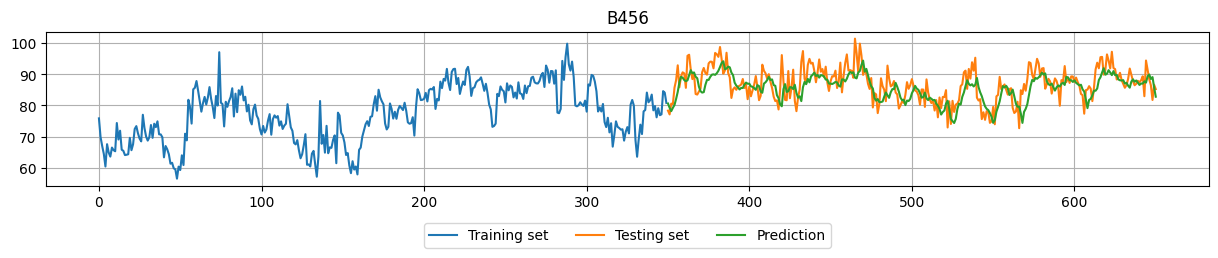

In [24]:
print('MSE : ', round(test_loss, 3))

# plot the result
y_train = [main.train_orig['MRR'][i] for i in range(0, len(main.train_orig), 316)]  
y_train = [y_train[i] for i in range(len(y_train)) if i % 2 == 0]
y_pred = np.array(value_result[0]).flatten()
y_truth = np.array(value_result[1])[:, 0].tolist()

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(len(y_train)), y_train, label='Train')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_truth, label='Test')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(['Training set', 'Testing set', 'Prediction'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.45))
plt.grid(True)
plt.show()